In [1]:
import torch
import torchvision
from matplotlib import pyplot as plt

from KNNClassifier import KNNClassifier
from KMeans import KMeans
import Metrics

### Define parameters and create the dataset

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
train = torchvision.datasets.MNIST('/files/', train=True, download=True)
X_train = train.data.reshape(-1, 28 * 28).to(device)
y_train = train.targets.to(device)

test = torchvision.datasets.MNIST('/files/', train=False, download=True)
X_test = test.data.reshape(-1, 28 * 28).to(device)
y_test = test.targets.to(device)

### Initialize the KNNClassifier and predict the classes of the test samples
In this case, k-means doesn't help, though it accelerates the prediction

In [4]:
D = KNNClassifier.getD(X_train, y_train).to(device)

n_neighbors = 3
n_clusters = 100
kmeans = KMeans(n_clusters=n_clusters)  
knn = KNNClassifier(n_neighbors=n_neighbors, metric=Metrics.MahalanobisMetric(shrinkage=True, normalization=True),
                     tukey_lambda=0.5, kmeans=kmeans, device=device).fit(D)
pred = knn.predict(X_test)
print('accuracy: ', knn.accuracy_score(y_test, pred))

accuracy:  96.67


### Plot the classifier's mistakes and get the nearest neighbors for those mistakes.
Note: This plot is a little outdated, as it uses Cosine Metric to get the nearest neighbor, instead of Mahalanobis 
Metric to get the nearest k-means centroid

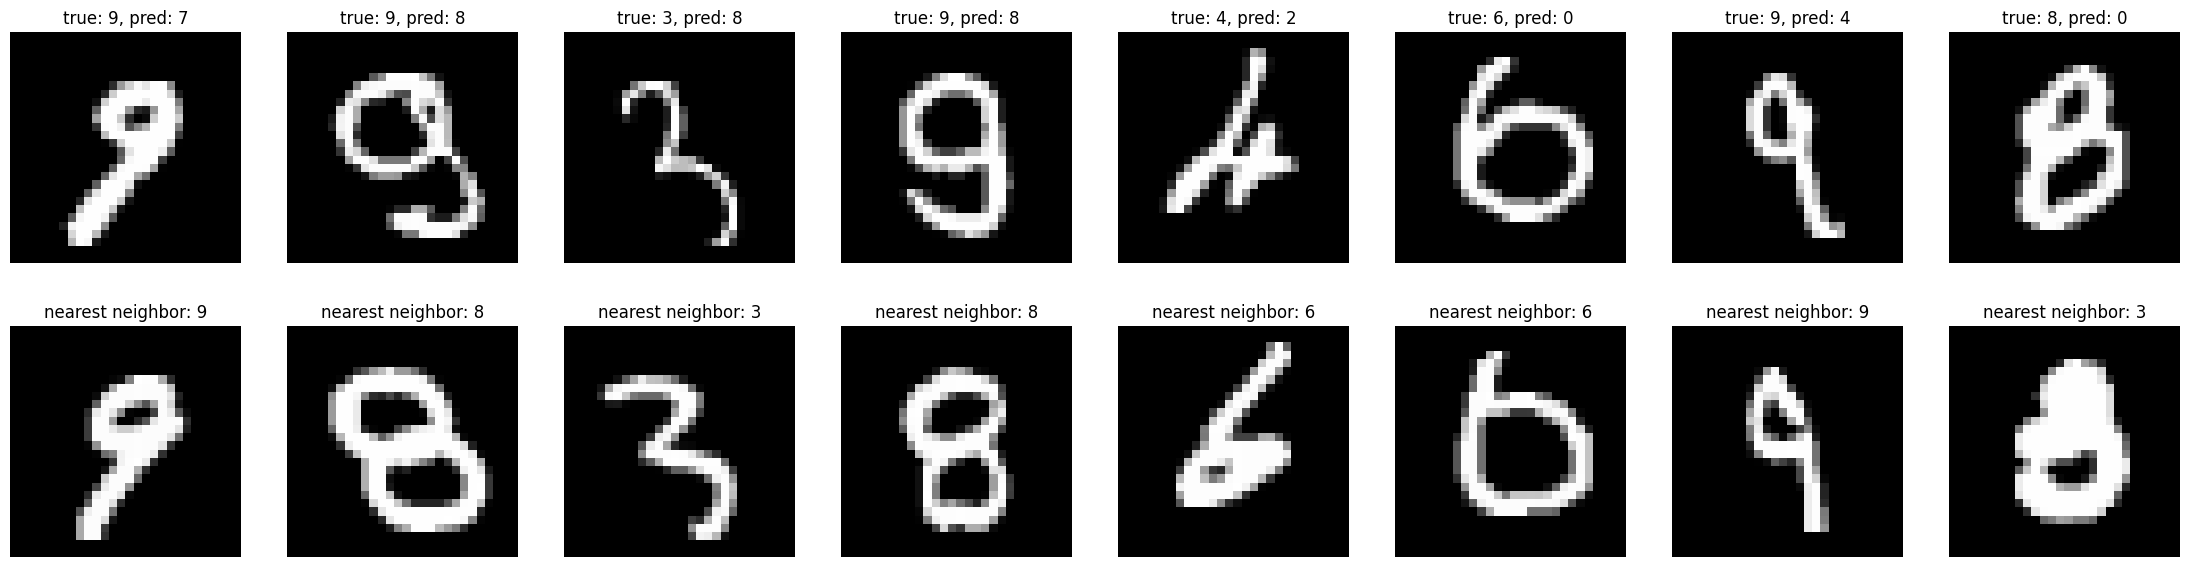

In [5]:
mistakes_ids = torch.argwhere(torch.ne(pred, y_test))

rows, columns = 2, 8
width, height = 3.5, 3.5
plt.figure(figsize=(columns * width, rows * height)) 

def get_nearest_neighbor(sample):
    distances = Metrics.CosineMetric().calculate(D, sample)
    index = torch.argmin(distances)
    return D.reshape(-1, 28*28)[index].reshape(28, 28), index // D.size(1)

for i in range(columns):
    plt.subplot(rows, columns, i + 1)
    image = X_test[mistakes_ids[i]].reshape(28, 28)
    plt.imshow(image.cpu(), cmap='gray')
    plt.title(f'true: {y_test[mistakes_ids[i]].item()}, pred: {pred[mistakes_ids[i]].item()}')
    plt.axis(False)
    
    plt.subplot(rows, columns, i + columns + 1)
    image, label = get_nearest_neighbor(X_test[mistakes_ids[i]])
    plt.imshow(image.cpu(), cmap='gray')
    plt.title(f'nearest neighbor: {label}')
    plt.axis(False)

plt.show()